### Tax Data by Income

From Tim:

I just found a better link to the income data I was telling you about:
http://www.cra-arc.gc.ca/gncy/stts/t1fnl-eng.html
 
<p>you can click on one of the three available years and then get the data in PDF or CSV (we had a poor intern clean up a machine converted version of the pdf). "Final Table 2 - All returns by total income class" is the one I think most interesting.
 
<p>there are a bunch of other tax filing related datasets available here: http://www.cra-arc.gc.ca/gncy/stts/menu-eng.html including 'T1 preliminary statistics' which are similar to the first link but run from 2006 to 2012.

I may want to switch to the preliminary files and try to convert those: http://www.cra-arc.gc.ca/gncy/stts/ntrm-eng.html

And here is a description of all the line items: http://www.cra-arc.gc.ca/gncy/stts/gb11/pst/fnl/dsctm-eng.html

In [1]:
import matplotlib

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.ticker import FuncFormatter

#### Data handling for plotting functions

In [3]:
def number_formatter(n):
    "Find the correct suffix, divide the original number, and return the new number + suffix"
    if 0 <= n < 1E3: 
        suffix = ' '
    elif 1E3 <= n < 1E6:
        suffix = 'k'
    elif 1E6 <= n < 1E9:
        suffix = 'M'
    elif 1E9 <= n < 1E12:
        suffix = 'B'
    elif 1E12 <= n < 1E15:
        suffix = 'T'
    else:
        suffix = 'really big!'
    
    order = {' ':1., 'k':1E3, 'M':1E6, 'B':1E9, 'T':1E12, 'really big!':1.}
    suffix2print = {' ':'', 'k':'k', 'M':'M', 'B':'B', 'T':'T', 'really big!':'really big!'}
    smaller_n = n / order[suffix]
    
    if smaller_n%1 < 0.0001: 
        return str(int(smaller_n)) + suffix2print[suffix]
    else: 
        return str(smaller_n) + suffix2print[suffix]
    
def _mpl_dollar_formatter(y, position): return '$' + number_formatter(y)

def _mpl_number_formatter(y, position): return number_formatter(y)

def _mpl_percent_formatter(y, position): return number_formatter(100 * y) + '%'
    
mpl_number_formatter = FuncFormatter(_mpl_number_formatter)
mpl_dollar_formatter = FuncFormatter(_mpl_dollar_formatter)
mpl_percent_formatter = FuncFormatter(_mpl_percent_formatter)

def bar_plot(values, title, labels=[], xformatter=None):
    f, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.barh(range(len(values)), values, align='center', color='grey', edgecolor='grey');
    ax.set_ylim([-1, len(values)])
    ax.set_yticks(range(len(values)))
    ax.set_yticklabels(labels)
    ax.vlines(ax.get_xticks(), ax.get_ybound()[0], ax.get_ybound()[1], color='white', linewidth=2)
    if xformatter: ax.xaxis.set_major_formatter(xformatter)
    ax.set_title(title)
    return f, ax

def remove_border(axes=None, top_ax=False, right_ax=False, left_ax=False, bottom_ax=False,
                  top_tick=False, right_tick=False, left_tick=False, bottom_tick=False):
    "Remove the border from a matplotlib plot"
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top_ax)
    ax.spines['right'].set_visible(right_ax)
    ax.spines['left'].set_visible(left_ax)
    ax.spines['bottom'].set_visible(bottom_ax)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    if top_tick: ax.xaxis.tick_top()
    if bottom_tick: ax.xaxis.tick_bottom()
    if left_tick: ax.yaxis.tick_left()
    if right_tick: ax.yaxis.tick_right()

In [9]:
ordered_cols = ['< $0', '< $5k', '$1 - 10k', '$5k - 10k', '$10k - 15k',
             '$15k - 20k', '$20k - 25k', '$25k - 30k', '$30k - 35k', 
             '$35k - 40k', '$40k - 45k', '$45k - 50k', 
             '$50k - 60k', '$60k - 70k', '$70k - 80k',
             '$80k - 90k', '$90k - 100k', '$100k - 150k', '$150k - 250k', '> $250k']

unit_figuring = {'$': {'$': '%', '#': '$', '-': '$'},
                 '#': {'$': '1/$', '#': '#', '-':'#'}}

x_label_figuring = {'$': {'$': '(as % of income)', '#': '(per return)', '-': ''},
                 '#': {'$': '# of returns per dollar of income', '#': '# of returns per return', '-': ''}}

mpl_formatters = {'$':mpl_dollar_formatter, '#':mpl_number_formatter, 
                  '%':mpl_percent_formatter}

def vector_division(numerator, denomonator):
    result = np.divide([float(n) for n in numerator], [float(n) for n in denomonator])
    return result

def get_row_data_as_list(df, cols, item_name, item_unit, tax_year):
    row = df.query("item == @item_name and type == @item_unit and tax_year == @tax_year")
    row_data = [row[c][row.index[0]] for c in cols]
    return row_data

def plot_item(df, item_name='', item_unit='$', divisor='', tax_year=2009):
    
    # ordered_cols excludes 'item', 'type', 'tax_year', 'total'
    numerator_data = get_row_data_as_list(df, ordered_cols, item_name, item_unit, tax_year)

    if divisor == "per_return":    
        denomonator_data = get_row_data_as_list(df, ordered_cols, 'total number of returns', '#', tax_year)
        denomonator_unit = '#'
    elif divisor == "per_dollar_income":
        denomonator_data = get_row_data_as_list(df, ordered_cols, 'total income assessed', '$', tax_year)
        denomonator_unit = '$'
    elif divisor == "avg_claim":
        denomonator_data = get_row_data_as_list(df, ordered_cols, item_name, '#', tax_year)
        denomonator_unit = '-'
    else:
        denomonator_data = np.ones_like(numerator_data)
        denomonator_unit = '-'

    plot_data = np.divide([float(n) for n in numerator_data], [float(n) for n in denomonator_data])

    final_unit = unit_figuring[item_unit][denomonator_unit]

    f, ax = bar_plot(plot_data, '', labels=ordered_cols, xformatter=mpl_formatters[final_unit])
    ax.set_xlabel(item_name + ' ' + x_label_figuring[item_unit][denomonator_unit] + "\n")
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_ticks_position('top')
    remove_border(ax, top_ax=True, top_tick=True)
    
    return f, ax

#### Loading the data

In [10]:
df = pd.DataFrame.from_csv('../data/combined_df.csv') #all_clean_tax_data.csv')

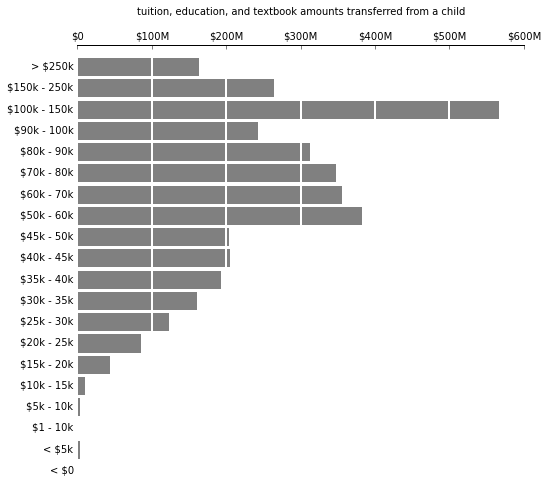

In [11]:
f, ax = plot_item(df, item_name='tuition, education, and textbook amounts transferred from a child')

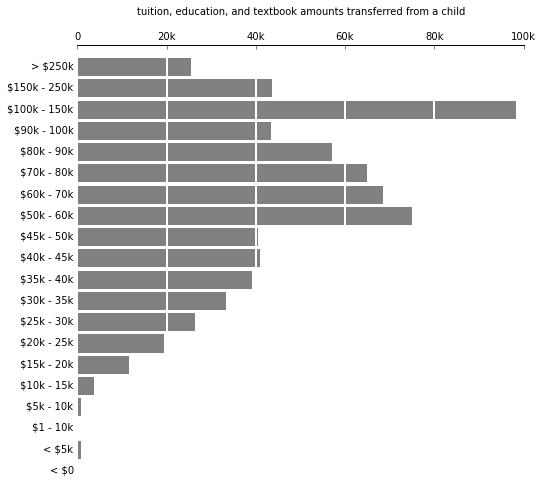

In [12]:
f, ax = plot_item(df, item_name='tuition, education, and textbook amounts transferred from a child', item_unit='#')

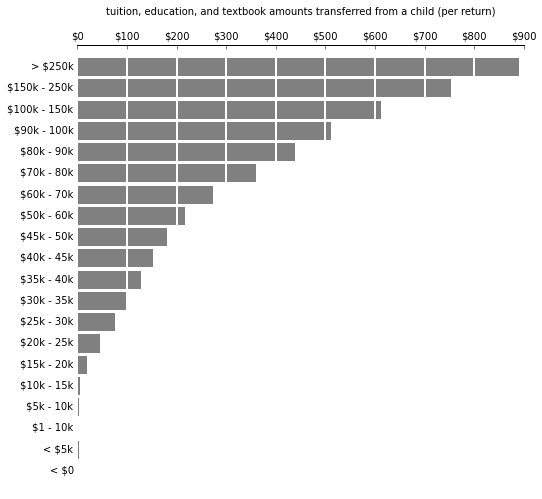

In [13]:
f, ax = plot_item(df, item_name='tuition, education, and textbook amounts transferred from a child', item_unit='$',divisor="per_return")

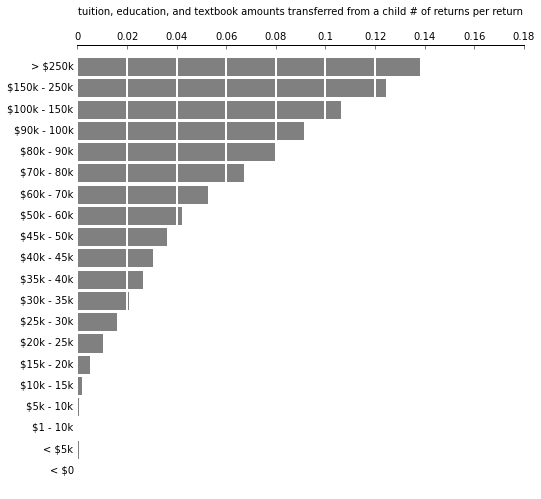

In [14]:
f, ax = plot_item(df, item_name='tuition, education, and textbook amounts transferred from a child', item_unit='#',divisor="per_return")

There are a few distinct types of plots we can make, all by income bucket:
* total value of all claims
* average value of each claim
* average value of claim per return
* average value per return as fraction of income (this may only make sense for seeing the average tax rate?)
* total number of tax claims
* fraction of returns with claim

### line plots 

In [15]:
divisor = "avg_claim"
item_name = 'net federal tax'
item_unit = '$'

In [16]:
def line_plot(df, item_name='', item_unit='$', divisor=''):
    def yr_frmt(n, pos): return str(int(n))
    rows = df.query("item == @item_name and type == @item_unit")
    all_years = list(set(rows.tax_year))
    stuff = {}
    for tax_year in all_years:
        numerator_data = get_row_data_as_list(df, ordered_cols, item_name, item_unit, tax_year)

        if divisor == "per_return":    
            denomonator_data = get_row_data_as_list(df, ordered_cols, 'total number of returns', '#', tax_year)
            denomonator_unit = '#'
        elif divisor == "per_dollar_income":
            denomonator_data = get_row_data_as_list(df, ordered_cols, 'total income assessed', '$', tax_year)
            denomonator_unit = '$'
        elif divisor == "avg_claim":
            denomonator_data = get_row_data_as_list(df, ordered_cols, item_name, '#', tax_year)
            denomonator_unit = '-'
        else:
            denomonator_data = np.ones_like(numerator_data)
            denomonator_unit = '-'

        plot_data = np.divide([float(n) for n in numerator_data], [float(n) for n in denomonator_data])
        stuff[tax_year] = dict(zip(ordered_cols, plot_data))

    final_unit = unit_figuring[item_unit][denomonator_unit]

    stuff2 = {}
    for c in ordered_cols:
        stuff2[c] = []
        for y in all_years:
            stuff2[c].append(stuff[y][c])
    
    f, ax = plt.subplots(1, 1, figsize=(15, 15))
    for c in ordered_cols: 
        ax.plot(all_years, stuff2[c], label=c)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
    ax.yaxis.set_major_formatter(mpl_formatters[final_unit])
    ax.xaxis.set_major_formatter(FuncFormatter(yr_frmt))

    return f, ax, stuff2

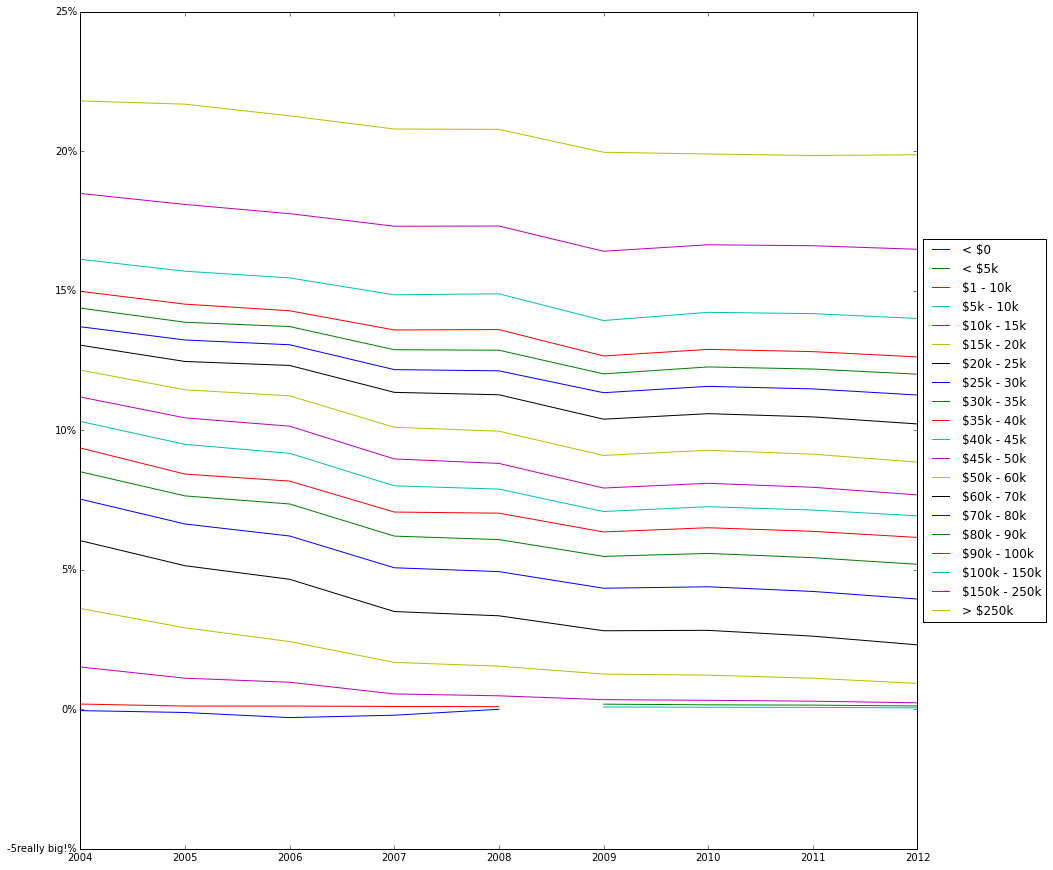

In [17]:
_, _, s = line_plot(df, item_name='net federal tax', item_unit='$', divisor='per_dollar_income')

In [18]:
for c in ordered_cols:
    print c, ',', str(np.round(100*(s[c][-1] - s[c][0]), 1)) + '%'

< $0 , nan%
< $5k , nan%
$1 - 10k , nan%
$5k - 10k , nan%
$10k - 15k , -1.3%
$15k - 20k , -2.7%
$20k - 25k , -3.7%
$25k - 30k , -3.6%
$30k - 35k , -3.3%
$35k - 40k , -3.2%
$40k - 45k , -3.4%
$45k - 50k , -3.5%
$50k - 60k , -3.3%
$60k - 70k , -2.8%
$70k - 80k , -2.4%
$80k - 90k , -2.4%
$90k - 100k , -2.4%
$100k - 150k , -2.1%
$150k - 250k , -2.0%
> $250k , -1.9%
